# Ejemplo de Large Language Model (LLM) InstructIR para realizar ajustes en Imágenes usando órdenes en Texto

Fuente: https://github.com/mv-lab/InstructIR

In [1]:
# @title Bajar e instalar InstructIR.git
import sys
import os

print("")

!git clone https://github.com/mv-lab/InstructIR.git
sys.path.append("InstructIR/")

print("")

os.chdir("InstructIR/")
!ls
print("")



Cloning into 'InstructIR'...
remote: Enumerating objects: 164, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 164 (delta 10), reused 10 (delta 10), pack-reused 149 (from 1)
Receiving objects: 100% (164/164), 87.86 MiB | 12.27 MiB/s, done.
Resolving deltas: 100% (45/45), done.
Updating files: 100% (87/87), done.

app.py	  data	       eval_instructir.py  LICENSE     predict.py		results    test.py
cog.yaml  datasets.py  images		   metrics.py  README.md		static	   text
configs   demo.ipynb   index.html	   models      requirements_gradio.txt	test-data  utils.py



In [2]:
#@title Cargar Librerías

import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import yaml
import random
import glob


from utils import *
from models import instructir

from text.models import LanguageModel, LMHead

SEED=42
seed_everything(SEED=SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Librerías cargadas.")


print("Device: ", device)

Librerías cargadas.
Device:  cpu


#Cargar Modelos

In [3]:
#@title Cargar Configuración para Modelos

CONFIG     = "configs/eval5d.yml"
LM_MODEL   = "models/lm_instructir-7d.pt"
MODEL_NAME = "models/im_instructir-7d.pt"

# parse config file
with open(os.path.join(CONFIG), "r") as f:
    config = yaml.safe_load(f)

cfg = dict2namespace(config)

print("Configuración definida: \n", cfg)


Configuración definida: 
 Namespace(llm=Namespace(model='TaylorAI/bge-micro-v2', model_dim=384, embd_dim=256, nclasses=7, weights=False), model=Namespace(arch='instructir', use_text=True, in_ch=3, out_ch=3, width=32, enc_blks=[2, 2, 4, 8], middle_blk_num=4, dec_blks=[2, 2, 2, 2], textdim=256, weights=False), test=Namespace(batch_size=1, num_workers=3, dn_datapath='test-data/denoising_testsets/', dn_datasets=['CBSD68', 'urban100', 'Kodak24'], dn_sigmas=[15, 25, 50], rain_targets=['test-data/Rain100L/target/'], rain_inputs=['test-data/Rain100L/input/'], haze_targets='test-data/SOTS/GT/', haze_inputs='test-data/SOTS/IN/', lol_targets='test-data/LOL/high/', lol_inputs='test-data/LOL/low/', gopro_targets='test-data/GoPro/target/', gopro_inputs='test-data/GoPro/input/'))


In [4]:
#@title Cargar Modelo InstructIR


print ("Creating InstructIR")
model = instructir.create_model(input_channels =cfg.model.in_ch, width=cfg.model.width, enc_blks = cfg.model.enc_blks,
                            middle_blk_num = cfg.model.middle_blk_num, dec_blks = cfg.model.dec_blks, txtdim=cfg.model.textdim)

print (device)
model = model.to(device)

################### LOAD IMAGE MODEL

assert MODEL_NAME, "Model weights required for evaluation"

print ("IMAGE MODEL CKPT:", MODEL_NAME)
model.load_state_dict(torch.load(MODEL_NAME, map_location=torch.device('cpu')), strict=True)

nparams   = count_params (model)
print ("Loaded weights!", nparams / 1e6)

Creating InstructIR
cpu
IMAGE MODEL CKPT: models/im_instructir-7d.pt
Loaded weights! 15.843363


<ipython-input-4-9ba806424659>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(MODEL_NAME, map_location=torch.device('cpu')), strict=True)

In [5]:
#@title Cargar Modelo de Lenguaje

if cfg.model.use_text:
    os.environ["TOKENIZERS_PARALLELISM"] = "false"

    # Initialize the LanguageModel class
    LMODEL = cfg.llm.model
    language_model = LanguageModel(model=LMODEL)
    lm_head = LMHead(embedding_dim=cfg.llm.model_dim, hidden_dim=cfg.llm.embd_dim, num_classes=cfg.llm.nclasses)
    lm_head = lm_head #.to(device)
    lm_nparams   = count_params (lm_head)

    print ("LMHEAD MODEL CKPT:", LM_MODEL)
    lm_head.load_state_dict(torch.load(LM_MODEL, map_location=torch.device('cpu')), strict=True)
    print ("Loaded weights!")

else:
    LMODEL = None
    language_model = None
    lm_head = None
    lm_nparams = 0

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.56k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/82.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/228 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/745 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/34.8M [00:00<?, ?B/s]

LMHEAD MODEL CKPT: models/lm_instructir-7d.pt
Loaded weights!


<ipython-input-5-066a7d5fda5d>:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lm_head.load_state_dict(torch.load(LM_MODEL, map_location=torch.device('cpu')), strict=True)

In [6]:
#@title Define funciones auxiliares para ejecutar

from PIL import Image

def load_imgFN(filename, norm=True, imageSize=None):
    imag = Image.open(filename).convert("RGB")
    if imageSize is not None:
      imag = imag.resize(imageSize, Image.LANCZOS)
    img = np.array(imag)
    if norm:
        img = img / 255.
        img = img.astype(np.float32)
    return img

def plot_all (images, figsize=(20,10), axis='off', names=None):
    nplots = len(images)
    fig, axs = plt.subplots(1,nplots, figsize=figsize, dpi=80,constrained_layout=True)
    for i in range(nplots):
        axs[i].imshow(images[i])
        if names: axs[i].set_title(names[i])
        axs[i].axis(axis)
    plt.show()



def process_img (image, prompt):
    """
    Given an image and a prompt, we run InstructIR to restore the image following the human prompt.
    image: RGB image as numpy array normalized to [0,1]
    prompt: plain python string,

    returns the restored image as numpy array.
    """

    torch.cuda.empty_cache()
    ##torch.cuda.reset_peak_memory_stats()

    # Convert the image to tensor
    y = torch.Tensor(image).permute(2,0,1).unsqueeze(0)

    # Get the text embedding (and predicted degradation class)
    lm_embd = language_model(prompt)
    lm_embd = lm_embd #.to(device)
    text_embd, deg_pred = lm_head (lm_embd)

    # Forward pass: Paper Figure 2
    x_hat = model(y, text_embd)

    # convert the restored image <x_hat> into a np array
    restored_img = x_hat[0].permute(1,2,0).cpu().detach().numpy()
    restored_img = np.clip(restored_img, 0. , 1.)
    return restored_img


def process(imageFN, prompt, imageSize=(128,128)):

  image = load_imgFN(imageFN, imageSize=imageSize)
  print("Procesando... (", imageFN,"&", prompt, ")", end=' ')
  restored_image = process_img(image, prompt)
  print("- Finalizado.")
  # save_rgb (restored_image, "result.png") # save the resultant image
  plot_all([image, restored_image], names=["Antes", "Después"], figsize=(10,5))


# definicion iniciales

# ejemplos prompt
ejemplos_ordenes = [ "please inprove the quality and resolution of the picture",
                    "Can you make it look stunning? like a professional photo",
                    "Retouch the picture as a professional photographer please",
                     "my image is too dark, I cannot see anything, can you fix it?",
                     "can you apply tone mapping?",
                    "Can you remove the little dots in the image? is very unpleasant",
                    "I love this photo, could you remove the raindrops? please keep the content intact" ]


# descarga lista de imágenes
imagPath = "images/"
listImgs = glob.glob(imagPath+'*.png')
if os.path.isdir(imagPath + "gradio_demo_images/"):
  listImgs.extend(  glob.glob(imagPath+'gradio_demo_images/*.png') )
listImgs.sort()

print("Funciones auxiliares definidas.")

Funciones auxiliares definidas.


# Ejecutar IntructIR:

GridBox(children=(Dropdown(description='Imagen a procesar:', options=('images/frog.png', 'images/gopro.png', '…

Procesando... ( images/frog.png & Can you remove the little dots in the image? is very unpleasant ) - Finalizado.


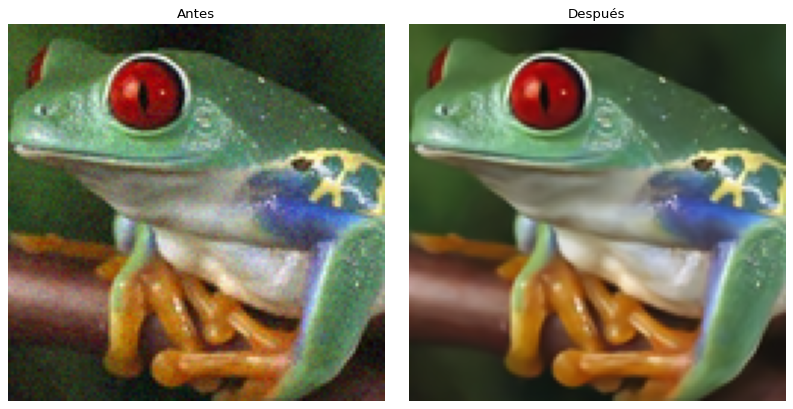

In [7]:
#@title Ejecutar usando imágenes de ejemplo del modelo 1

from IPython.display import clear_output
import ipywidgets as widgets
from ipywidgets import Box, Layout


# auxiliar para que muestre bien la descripción
style_3D = {'description_width': 'initial', 'width': 'max-content'}

ImagCombo = widgets.Dropdown(
    options = listImgs,
    value = listImgs[0],
    description = 'Imagen a procesar:',
    style=style_3D,
    disabled = False,
)

promptCombo = widgets.Dropdown(
    options = ejemplos_ordenes,
    value = ejemplos_ordenes[0],
    description = 'Prompt a ejecutar:',
    style=style_3D,
    disabled = False,

)

promptOther = widgets.Text(
    value='',
    placeholder='Escribir otro prompt en inglés',
    description='Other Prompt:',
    disabled=False
)

button = widgets.Button(description="Ejecutar")


prueba_ui = widgets.GridBox(children=[ImagCombo, promptCombo, promptOther, button],
        layout=Layout(
            width='100%',
            grid_template_rows='auto auto auto auto',
            grid_template_columns='100%',
        )
      )

def hacerNada():
  return

# se define esta función para que se ocupe de hacer el resfresco al tocar el botón solamente
def on_button_clicked(b):
  clear_output()
  display(prueba_ui)
  ut3D = widgets.interactive_output(hacerNada, {})
  # obtiene parámetros
  imgFN = ImagCombo.value
  if promptOther.value != "":
    prompt = promptOther.value
  else:
    prompt = promptCombo.value
  # procesa
  process(imgFN, prompt)


# genera interface
button.on_click(on_button_clicked)
display(prueba_ui)


GridBox(children=(Dropdown(description='Imagen a procesar:', options=('images/frog.png', 'images/gopro.png', '…

Procesando... ( images/frog.png & make the photo look vintage please ) - Finalizado.


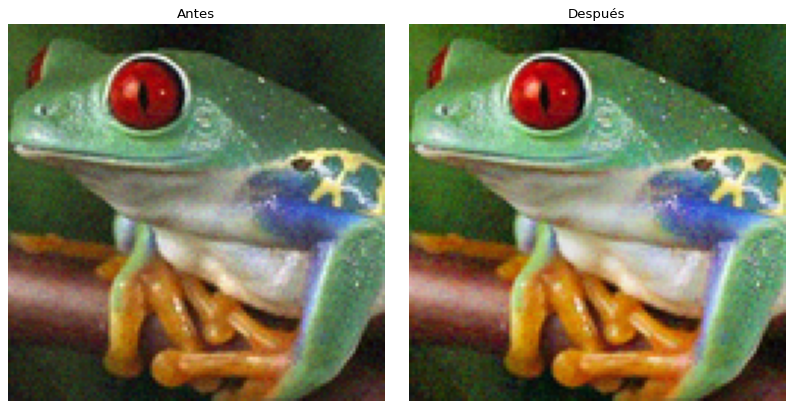

In [8]:
#@title Ejecutar usando imágenes de ejemplo del modelo 2

# genera interface
button.on_click(on_button_clicked)
display(prueba_ui)

GridBox(children=(Text(value='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSzEBkGm_1w3qZCYNN53TSqNIKe…

Procesando... ( /content/donwload_image.jpg & Retouch the picture as a professional photographer please ) - Finalizado.


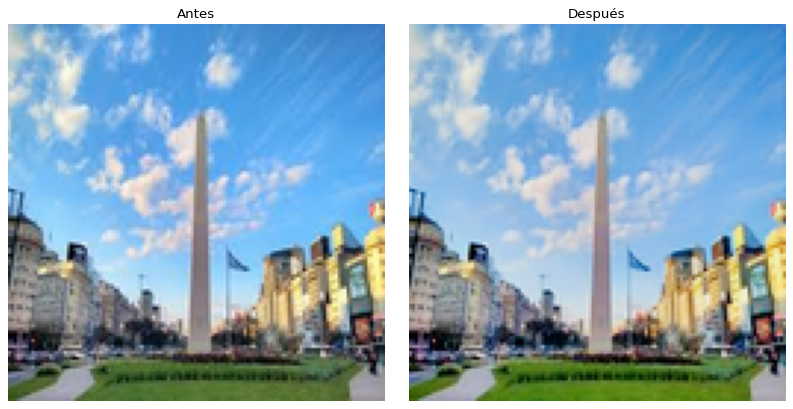

In [9]:
#@title Ejecutar usando imágenes de la web

from IPython.display import clear_output
import ipywidgets as widgets
from ipywidgets import Box, Layout
import glob


# auxiliar para que muestre bien la descripción
style_3D = {'description_width': 'initial', 'width': 'max-content'}

imagURL = widgets.Text(
    placeholder='Escribir URL de la imagen a procesar',
    description='Image URL:',
    value="https://static.fundacion-affinity.org/cdn/farfuture/54n76QrL7YrsyLSTQlAzpJnwCz54nW1MsmYw2QJcIII/mtime:1528830295/sites/default/files/antrozoologia-conociendo-el-vinculo-entre-personas-y-otros-animales.jpg",
    disabled=False
)

promptCombo_URL = widgets.Dropdown(
    options = ejemplos_ordenes,
    value = ejemplos_ordenes[0],
    description = 'Prompt a ejecutar:',
    style=style_3D,
    disabled = False,

)

promptOther_URL = widgets.Text(
    value='',
    placeholder='Escribir otro prompt en inglés',
    description='Other Prompt:',
    disabled=False
)

button_URL = widgets.Button(description="Ejecutar")


pruebaURL_ui = widgets.GridBox(children=[imagURL, promptCombo_URL, promptOther_URL, button_URL],
        layout=Layout(
            width='100%',
            grid_template_rows='auto auto auto auto',
            grid_template_columns='100%',
        )
      )

def hacerNada():
  return


import requests # request img from web
import shutil # save img locally


def downloadImage(imagen_URL):
    # baja la imagen
    URL_file_name = "/content/donwload_image.jpg"
    res = requests.get(imagen_URL, stream = True)
    if res.status_code == 200:
        with open(URL_file_name,'wb') as f:
            shutil.copyfileobj(res.raw, f)
        return URL_file_name
    else:
        print('No se puede descargar la imagen')
    return None

# se define esta función para que se ocupe de hacer el resfresco al tocar el botón solamente
def on_button_URL_clicked(b):
  clear_output()
  display(pruebaURL_ui)
  ut3D = widgets.interactive_output(hacerNada, {})
  # obtiene parámetros
  imgFN = downloadImage(imagURL.value)
  if imgFN is None:
    return
  if promptOther_URL.value != "":
    prompt = promptOther_URL.value
  else:
    prompt = promptCombo_URL.value
  # procesa
  process(imgFN, prompt)


# genera interface
button_URL.on_click(on_button_URL_clicked)
display(pruebaURL_ui)
